In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Loading

In [2]:
from pathlib import Path
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import roc_curve, roc_auc_score
from notebooks.utils import PandasTableFormatter
from mol_gen_docking.evaluation.diversity_aware_top_k import diversity_aware_top_k
from notebooks.utils import *

FIG_PATH = "MolGenDocking-latex/Figures/Results/MolProp"
os.makedirs(FIG_PATH, exist_ok=True)


In [25]:
MOLSTRAL_PATH = Path("MolGenOutput/polaris")

files = [f for f in MOLSTRAL_PATH.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
files = [f for f in files if not any(avoid in f.name for avoid in ["MiniMax", "R1", "ether0"])]
files = sorted(files)
full_df = load_molprop_results(files)

100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


In [26]:
from tqdm import tqdm
tqdm.pandas()

full_df = full_df.groupby(["Model", "prompt_id", "Task"]).head(5)
# For each model, drop tasks where not all prompt_ids appear
# Get the set of prompt_ids per task (reference)
prompt_ids_per_task = full_df.groupby("Task").prompt_id.apply(set)
# Get the set of prompt_ids per (Model, Task)
prompt_ids_per_model_task = full_df.groupby(["Model", "Task"]).prompt_id.apply(set)
# Check which (Model, Task) combinations have all prompt_ids
valid_model_tasks = prompt_ids_per_model_task.reset_index()
valid_model_tasks["all_prompts"] = valid_model_tasks.apply(
    lambda x: x.prompt_id == prompt_ids_per_task[x.Task], axis=1
)
valid_model_tasks = valid_model_tasks[valid_model_tasks["all_prompts"]][["Model", "Task"]]
# Filter using merge (much faster than row-wise apply)
full_df = full_df.merge(valid_model_tasks, on=["Model", "Task"], how="inner")


In [27]:
df_validity_no_numeric_mistake = full_df.groupby(["Model", "prompt_id", "Task", "objectives"])[["validity", "contains_numeric"]].apply(
    lambda x: any(x.validity) or not any(x.contains_numeric)
).reset_index().rename(columns={0: "non-valid-and-numeric"})

df_validity = full_df.groupby(["Model", "prompt_id", "Task", "objectives"]).validity.apply(
    lambda x: any(x)
).reset_index()

# Merge to get contains_numeric info
df_validity = df_validity.merge(
    df_validity_no_numeric_mistake,
    on=["Model", "prompt_id", "Task", "objectives"],
    how="left"
)


df_validity = df_validity.groupby(["Model", "Task", "objectives"])[["validity", "non-valid-and-numeric"]].mean().reset_index()
df_validity

,Model,Task,objectives,validity,non-valid-and-numeric
0,ChemDFM-R,ames,classification,1.000000,1.000000
1,ChemDFM-R,antiviral-potency,regression,0.960784,1.000000
2,ChemDFM-R,az-logd,regression,1.000000,1.000000
3,ChemDFM-R,az-ppb-clearance,regression,1.000000,1.000000
4,ChemDFM-R,bbb,classification,1.000000,1.000000
...,...,...,...,...,...
156,gemma-3,mic-clearance-az,regression,1.000000,1.000000
157,gemma-3,pgp,classification,1.000000,1.000000
158,gemma-3,pkis2-drewry,classification,0.988208,0.990566
159,gemma-3,solubility,regression,0.951158,0.990607


/tmp/ipykernel_53374/2483244855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj["missed"] = 1- df_obj["validity"]
/tmp/ipykernel_53374/2483244855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj["missed-and-numeric"] =1 - df_obj["non-valid-and-numeric"]
/tmp/ipykernel_53374/2483244855.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right'

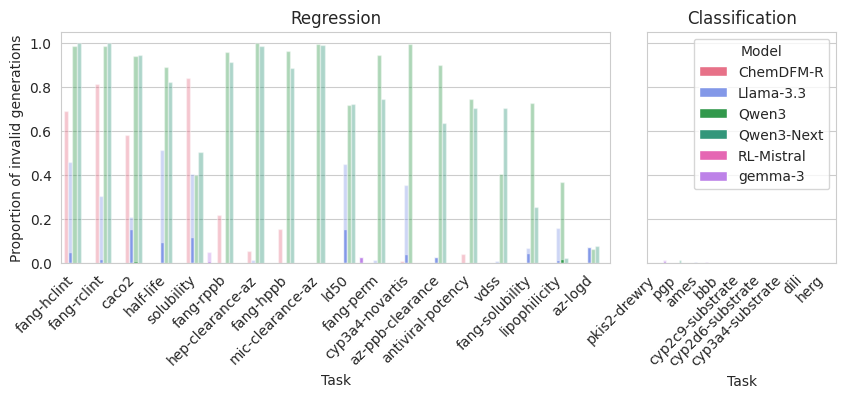

In [28]:
prop_cls = df_validity[df_validity.objectives == "classification"].Task.nunique() / df_validity.Task.nunique()/1.3

fig, axes = plt.subplots(1,2,figsize=(10,3), gridspec_kw={"wspace":0.1, "width_ratios": [1-prop_cls, prop_cls]}, sharey=True)

for obj, ax in zip(["regression", "classification"], axes):
    df_obj = df_validity[df_validity.objectives == obj]
    x_order = df_obj.groupby("Task").validity.mean().sort_values().index.tolist()
    df_obj["missed"] = 1- df_obj["validity"]
    df_obj["missed-and-numeric"] =1 - df_obj["non-valid-and-numeric"]
    kwargs = dict( data=df_obj, x="Task", hue="Model", palette=CMAP_MODELS, order=x_order, ax=ax,)
    sns.barplot(
        y="missed-and-numeric",
        legend=obj == "classification",
        alpha = 1,
        **kwargs
    )
    sns.barplot(
        y="missed",
        legend=False,
        alpha = 0.4,
        **kwargs
    )
    ax.set_title(obj.capitalize())
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    if ax == axes[0]:
        ax.set_ylabel("Proportion of invalid generations")
    else:
        ax.set_ylabel("")

fig.savefig(f"{FIG_PATH}/valid_.pdf", bbox_inches="tight")

# Metric Computation

## Regression

In [29]:
# Compute Spearman_corr
df = full_df[full_df.objectives == "regression"]
def get_yagg(values):
    values = [v for v in values if not np.isnan(v)]
    if len(values) == 0:
        return np.nan
    return np.mean(values)

df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
correlations = df[df.validity == 1].groupby(["Model", "Task"])[["gt", "y_agg"]].corr(method="spearman").loc[pd.IndexSlice[:, :, "gt"], "y_agg"]
correlations = correlations.reset_index(level=2, drop=True)

coverage = df.groupby(["Model", "Task"]).validity.mean()

corr_cov_score = (correlations+1) * coverage / 2
corr_cov_score.fillna(0, inplace=True)

corr_cov_score

/tmp/ipykernel_53374/787785677.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)


Model      Task             
ChemDFM-R  antiviral-potency    0.362503
           az-logd              0.857419
           az-ppb-clearance     0.469062
           caco2                0.070401
           cyp3a4-novartis      0.449145
                                  ...   
gemma-3    ld50                 0.227605
           lipophilicity        0.632676
           mic-clearance-az     0.618798
           solubility           0.449652
           vdss                 0.568558
Length: 107, dtype: float64

## Classification

In [30]:
df = full_df[full_df.objectives == "classification"]

def get_yagg(values):
    values = [v for v in values if not np.isnan(v)]
    if len(values) == 0:
        return np.nan
    return np.round(np.mean(values) + 1e-8 * values[0]).clip(0,1)

df["y_agg"] = df.groupby(["Model", "Task", "prompt_id"]).y.transform(get_yagg)

accuracy = df[df.validity == 1].groupby(
    ["Model", "Task"]
)[["gt", "y_agg"]].apply(
    lambda x: np.nanmean((x["gt"]== x["y_agg"]))
)
coverage = df.groupby(["Model", "Task"]).validity.mean()
accuracy = accuracy * coverage
accuracy.fillna(0, inplace=True)

accuracy

/tmp/ipykernel_53374/4145113119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "Task", "prompt_id"]).y.transform(get_yagg)


Model       Task            
ChemDFM-R   ames                0.483262
            bbb                 0.716923
            cyp2c9-substrate    0.822430
            cyp2d6-substrate    0.700935
            cyp3a4-substrate    0.476636
            dili                0.473684
            herg                0.333333
            pgp                 0.446154
            pkis2-drewry        0.844340
Llama-3.3   ames                0.524635
            bbb                 0.814154
            cyp2c9-substrate    0.177570
            cyp2d6-substrate    0.289720
            cyp3a4-substrate    0.523364
            dili                0.526316
            herg                0.704762
            pgp                 0.553846
            pkis2-drewry        0.158019
Qwen3       ames                0.653219
            bbb                 0.467077
            cyp2c9-substrate    0.710280
            cyp2d6-substrate    0.669159
            cyp3a4-substrate    0.614953
            dili            

## Add to table

In [31]:
# Join regression metrics
reg_metric = corr_cov_score.reset_index().rename(columns={0: "Metric"})
cls_metric = accuracy.reset_index().rename(columns={0: "Metric"})

full_df = full_df.drop(columns=["Metric"], errors="ignore")
full_df = full_df.merge(
    pd.concat([reg_metric, cls_metric]),
    on=["Model", "Task"],
    how="left"
)
full_df

,prompt_id,reward,gt,y,norm_var,model,n_props,properties,objectives,validity,Task,match,contains_numeric,gen_id,Model,Metric
0,novartis:novartis-cyp3a4-v1_train_15,-42.478431,-2.172000,-0.1177,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n-0.1177\n,True,0,ChemDFM-R,0.449145
1,novartis:novartis-cyp3a4-v1_train_15,0.000000,-2.172000,NaN,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,False,cyp3a4-novartis,\nNo\n,False,1,ChemDFM-R,0.449145
2,novartis:novartis-cyp3a4-v1_train_15,-34.482031,-2.172000,-0.3162,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n-0.3162\n,True,2,ChemDFM-R,0.449145
3,novartis:novartis-cyp3a4-v1_train_15,-56.839283,-2.172000,0.1974,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n0.1974\n,True,3,ChemDFM-R,0.449145
4,novartis:novartis-cyp3a4-v1_train_15,-23.497111,-2.172000,-0.6300,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n-0.6300\n,True,4,ChemDFM-R,0.449145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386005,biogen:adme-fang-rppb-reg-v1_train_108,-2.236208,-0.742321,0.6000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,0.6,True,4,gemma-3,0.512369
386006,biogen:adme-fang-rppb-reg-v1_train_108,-24.153910,-0.742321,3.0000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,3.0-4.5,True,0,gemma-3,0.512369
386007,biogen:adme-fang-rppb-reg-v1_train_108,-16.734728,-0.742321,2.4000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,2.4,True,1,gemma-3,0.512369
386008,biogen:adme-fang-rppb-reg-v1_train_108,-10.608717,-0.742321,1.8000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,1.8,True,2,gemma-3,0.512369


# Plots

In [32]:
KEY = "Metric"
table = full_df.groupby(["Model", "Task", "objectives"])[KEY].mean().reset_index()
MODEL_ORDER = list(CMAP_MODELS.keys())

task_order = table.groupby(["Model", "Task"])[KEY].mean().reset_index().groupby("Task")[KEY].max().sort_values( ascending=False).index

table = table.set_index(["Task"]).loc[task_order].reset_index()
table

,Task,Model,objectives,Metric
0,az-logd,ChemDFM-R,regression,0.857419
1,az-logd,Llama-3.3,regression,0.297862
2,az-logd,Qwen3,regression,0.384878
3,az-logd,Qwen3-Next,regression,0.378238
4,az-logd,RL-Mistral,regression,0.643487
...,...,...,...,...
156,fang-solubility,Llama-3.3,regression,0.437978
157,fang-solubility,Qwen3,regression,0.038298
158,fang-solubility,Qwen3-Next,regression,0.168784
159,fang-solubility,RL-Mistral,regression,0.434603


# Heatmap

In [33]:
MODEL_ORDER = full_df[full_df.objectives == "regression"].groupby("Model")[KEY].mean().sort_values().index.tolist()

In [34]:
def plot_heatmap(table, axes, title_name, split_val, vmin=0, vmax=1, annot_size=10):
    ax = axes[0]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "Task")
    col_order = pivoted.max().sort_values(ascending=False).index
    pivoted = pivoted.loc[MODEL_ORDER,col_order]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": annot_size}
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
    ax.set_title(title_name)

    ax = axes[1]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "objectives")
    pivoted = pivoted.loc[MODEL_ORDER]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": annot_size}
    )
    ax.set_xlabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
    ax.set_title(f"Avg.\n{title_name}")


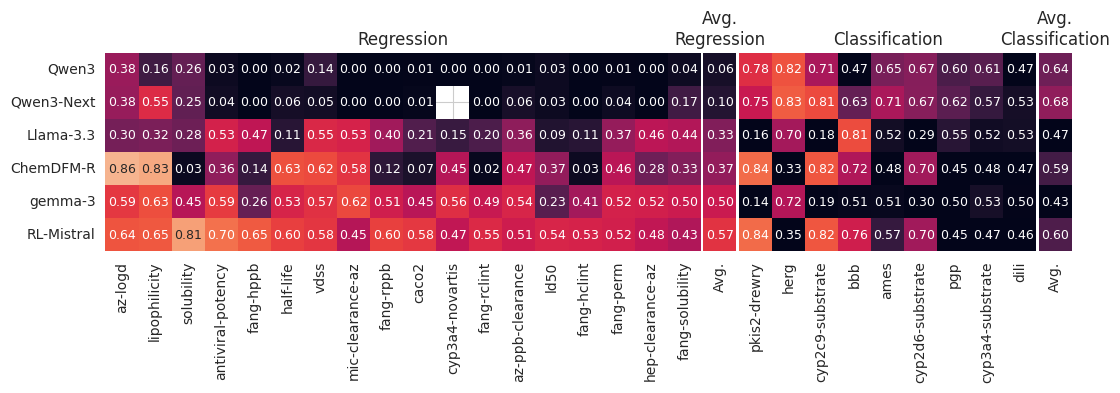

In [35]:
n_tot_cols = table.Task.nunique() + 2
n_rows = table.Model.nunique()

reg_ratio = table[table.objectives == "regression"].Task.nunique() / n_tot_cols
cls_ratio = table[table.objectives == "classification"].Task.nunique() / n_tot_cols

fig, axes = plt.subplots(
    1,
    4,
    figsize = (0.43*n_tot_cols,0.43 * n_rows),
    sharey=True,
    gridspec_kw = {
        "width_ratios":[reg_ratio, 1/n_tot_cols, cls_ratio,  1/n_tot_cols],
        "wspace":0.01,
    }
)

plot_heatmap(table, [axes[0],axes[1]], "Regression", "regression", annot_size=9)
plot_heatmap(table, [axes[2],axes[3]], "Classification", "classification", vmin = 0.5, vmax=1, annot_size= 9)

for ax in axes[1:]:
    ax.set_ylabel("")

fig.savefig(f"{FIG_PATH}/molecular_proppred_heatmap.pdf", bbox_inches="tight")

# Radar Charts

In [36]:
REMOVE_MODELS = [
    # "ether0", "R1-Llama", "R1-Qwen", "MiniMax-M2", "Qwen3"
]
TO_HIGHLIGHT = [
    "RL-Mistral", #"Qwen3-Next"
]

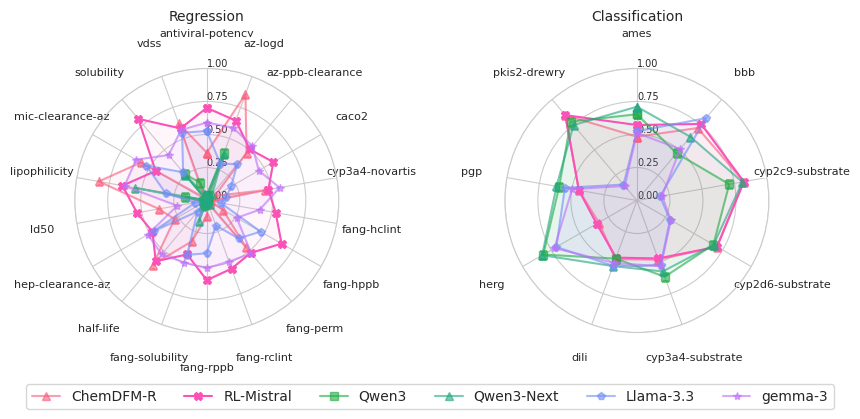

In [37]:
# Radar charts for classification and regression
from math import pi
from notebooks.utils import CMAP_MODELS, MARKER_MODELS


def plot_radar(ax, table, split_val, title, vmin=0, vmax=1):
    model_order = [m for m in CMAP_MODELS.keys() if not m in REMOVE_MODELS and m in table.Model.unique()]
    data = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "Task")
    categories = data.columns.tolist()
    n_cats = len(categories)

    # Compute angle for each category
    angles = [n / float(n_cats) * 2 * pi for n in range(n_cats)]
    angles += angles[:1]  # Complete the loop

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8, zorder=120)

    # Move labels further from the plot to avoid overlap with grid
    ax.tick_params(axis='x', pad=15)

    # Draw ylabels
    ax.set_rlabel_position(0)
    yticks = np.linspace(vmin, vmax, 5)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.2f}" for y in yticks], size=7)
    ax.set_ylim(vmin, vmax)

    # Plot each model
    for model in [m for m in CMAP_MODELS if m in model_order]:
        values = data.loc[model].tolist()
        values += values[:1]  # Complete the loop
        color = CMAP_MODELS.get(model, None)
        marker = MARKER_MODELS[model]  # Default to circle if not in MARKER_MODELS
        ax.plot(
            angles,
            values,
            linewidth=1.5,
            linestyle='solid',
            label=model,
            color=color,
            marker=marker,
            markersize=6,
            alpha = 1.0 if model in TO_HIGHLIGHT else 0.6
        )
        ax.fill(angles, values, alpha=0.05, color=color)

    ax.set_title(title, size=10, y=1.15)
    # Ensure tick labels are drawn on top
    for label in ax.get_xticklabels():
        label.set_zorder(0)
        label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=1., pad=1.))

fig, axes = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=dict(polar=True))

plot_radar(axes[0], table[~table.Model.isin(REMOVE_MODELS)], "regression", "Regression", vmin=0, vmax=1)
plot_radar(axes[1], table[~table.Model.isin(REMOVE_MODELS)], "classification", "Classification", vmin=0., vmax=1)

# Single legend below both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
fig.savefig(f"{FIG_PATH}/molecular_proppred_radar.pdf", bbox_inches="tight")
plt.show()